## calculate the probabilities for terciles, deciles and percentiles (0.02 then 0.05 to 0.95) categories for a 'realtime' forecast, with respect to the lead-time dependent monthly and seasonal hindcast climatologies, for each of the 8 C3S GCMs (ECMWF, UKMO, METEO-FRANCE, DWD, CMCC, NCEP, JMA and ECCC)

This notebook:   
    
1) reads the latest forecasts from the C3S MME [ECMWF, UKMO, METEO-FRANCE, DWD, CMCC, NCEP, JMA and ECCC]  
2) preprocesses, converts to monthly / seasonal rainfall accumulations   
3) reads the leadtime-dependent terciles, deciles and percentiles (0.02 then 0.05 to 0.95) climatologies corresponding to the initial month of the forecast  
4) calculate the probabilities for each quantile category as the proportion of the GCM's ensemble members  
5) saves to disk these probabilities for later use and mapping   

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from calendar import month_name

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr

In [3]:
import pathlib
HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

### import local functions for the processing of the C3S forecasts 

In [4]:
sys.path.append('../..')

In [5]:
from ICU_Water_Watch import C3S, domains

In [6]:
domain = domains.domains['C3S_download']

In [7]:
domain

[100, 240, -50, 30]

### provider (always CDS for now)

In [8]:
provider = 'CDS'

### variable name

In [9]:
varname = 'tprate'

### period (`monthly` or `seasonal`)

In [10]:
# period = 'monthly'
period = 'seasonal'

### provider 

In [11]:
provider = 'CDS'

### list of GCMs 

In [12]:
list_GCMs = ['ECMWF','UKMO','METEO_FRANCE','CMCC','DWD', 'NCEP', 'JMA', 'ECCC']

### lag in months (if need to process older forecasts)

In [13]:
lag = 1

### get today's date 

In [14]:
date = datetime.utcnow()

### apply lag 

In [15]:
date = date - relativedelta(months=lag)

In [16]:
print(f"will process forecasts issued in {date:%B %Y}")

will process forecasts issued in September 2021


### path to the GCMs **hindcast datasets** and **climatologies** 

In [17]:
gcm_path = pathlib.Path(f'/media/nicolasf/END19101/ICU/data/{provider}/operational/hindcasts')

### path to where the **realtime forecasts** have been downloaded 

In [18]:
forecasts_path = pathlib.Path(f'/media/nicolasf/END19101/ICU/data/{provider}/operational/forecasts')

In [19]:
forecasts_path

PosixPath('/media/nicolasf/END19101/ICU/data/CDS/operational/forecasts')

### output path for the probabilistic forecast files 

In [20]:
opath = CWD.parents[1].joinpath("outputs/C3S")

In [21]:
if not opath.exists(): 
    opath.mkdir(parents=True)

### get year and month 

In [22]:
year, month =  date.year, date.month

### loop over the GCMs here

In [23]:
GCM = 'ECMWF'

In [24]:
clim_path = gcm_path.joinpath(f'CLIMATOLOGY/{GCM}')

In [25]:
clim_path

PosixPath('/media/nicolasf/END19101/ICU/data/CDS/operational/hindcasts/CLIMATOLOGY/ECMWF')

In [26]:
tercile_climatology = xr.open_dataset(clim_path.joinpath(f"{GCM}_{period}_tercile_climatology_{str(month).zfill(2)}.netcdf"), engine='netcdf4')

In [27]:
tercile_climatology

<xarray.Dataset>
Dimensions:      (month: 1, lon: 121, lat: 81, step: 3, quantile: 2)
Coordinates:
  * month        (month) int64 9
  * lon          (lon) float32 120.0 121.0 122.0 123.0 ... 238.0 239.0 240.0
  * lat          (lat) float32 -50.0 -49.0 -48.0 -47.0 ... 27.0 28.0 29.0 30.0
  * step         (step) int64 3 4 5
  * quantile     (quantile) float64 0.3333 0.6666
Data variables:
    precip       (month, quantile, step, lat, lon) float64 ...
    n_instances  (month) int64 ...

In [28]:
tercile_climatology = domains.extract_domain(tercile_climatology, domain)

In [29]:
tercile_climatology

<xarray.Dataset>
Dimensions:      (month: 1, lon: 121, lat: 81, step: 3, quantile: 2)
Coordinates:
  * month        (month) int64 9
  * lon          (lon) float32 120.0 121.0 122.0 123.0 ... 238.0 239.0 240.0
  * lat          (lat) float32 -50.0 -49.0 -48.0 -47.0 ... 27.0 28.0 29.0 30.0
  * step         (step) int64 3 4 5
  * quantile     (quantile) float64 0.3333 0.6666
Data variables:
    precip       (month, quantile, step, lat, lon) float64 244.7 244.0 ... 75.26
    n_instances  (month) int64 600

In [30]:
x = xr.open_dataset(forecasts_path.joinpath(f"{GCM}/{varname.upper()}/ensemble_seas_forecasts_{varname}_from_{year}_{str(month).zfill(2)}_{GCM}.netcdf"), engine='netcdf4')

In [31]:
x

<xarray.Dataset>
Dimensions:    (longitude: 141, latitude: 81, number: 51, time: 5)
Coordinates:
  * longitude  (longitude) float32 100.0 101.0 102.0 103.0 ... 238.0 239.0 240.0
  * latitude   (latitude) float32 30.0 29.0 28.0 27.0 ... -48.0 -49.0 -50.0
  * number     (number) int32 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * time       (time) datetime64[ns] 2021-10-01 2021-11-01 ... 2022-02-01
Data variables:
    tprate     (time, number, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-09-21 00:57:53 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

In [32]:
x = C3S.preprocess_GCM(x)

### convert from mm/day to mm/month 

x = C3S.convert_rainfall(x, varin='tprate', varout='precip', leadvar='step', timevar='time', dropvar=True)

### just in case, remove potential missing fields (members)

x = x.dropna(dim='member')

### make sure we have the same domain for the climatologies and the latest forecasts

x = domains.extract_domain(x, domain)

# calculates the seasonal values if period == seasonal

if period == 'seasonal': 

    print("Calculating the seasonal (3 months) accumulations")

    x = x.rolling({'step':3}, min_periods=3, center=False).sum('step') 

    # get rid of the 2 first steps, which by definition contain missing values 

    x = x.sel(step=slice(3, None))

### checks that the initial month corresponds indeed to what we defined earlier 

if (x.time.dt.year != year) or (x.time.dt.month != month): 

    print(f"issue with the initial date in the latest forecast, expected {year}-{month}, got {x.time.dt.year}-{x.time.dt.month}")

### Now calculates the tercile category for each member



unit is m s**-1, converting to mm/day

now converting to mm/month, converted precipitation will be held in var = precip
Calculating the seasonal (3 months) accumulations


In [33]:
terciles_category = C3S.get_GCM_category_digitize(x, tercile_climatology.squeeze(), varname='precip', dim='quantile')

In [34]:
terciles_category

<xarray.Dataset>
Dimensions:  (time: 1, lon: 121, lat: 81, member: 51, step: 3)
Coordinates:
  * time     (time) datetime64[ns] 2021-09-01
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 237.0 238.0 239.0 240.0
  * lat      (lat) float32 -50.0 -49.0 -48.0 -47.0 -46.0 ... 27.0 28.0 29.0 30.0
  * member   (member) int32 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * step     (step) int64 3 4 5
    month    int64 9
Data variables:
    precip   (time, step, member, lat, lon) int64 1 1 1 1 1 1 1 ... 2 2 2 3 3 3

In [35]:
terciles_category_percent = C3S.calculate_quantiles_probabilities(terciles_category, ncategories=3)

In [36]:
terciles_category_percent

<xarray.Dataset>
Dimensions:  (tercile: 3, time: 1, step: 3, lat: 81, lon: 121)
Coordinates:
  * time     (time) datetime64[ns] 2021-09-01
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 237.0 238.0 239.0 240.0
  * lat      (lat) float32 -50.0 -49.0 -48.0 -47.0 -46.0 ... 27.0 28.0 29.0 30.0
  * step     (step) int64 3 4 5
    month    int64 9
  * tercile  (tercile) int64 1 2 3
Data variables:
    precip   (tercile, time, step, lat, lon) float64 41.18 41.18 ... 27.45 23.53

In [37]:
terciles_category_percent.attrs['pct_values'] = tercile_climatology['quantile'].data

In [38]:
terciles_category_percent_parametrized = xr.open_dataset("/home/nicolasf/Desktop/tercile_probs_ECMWF_seasonal_parametrized.nc")

In [39]:
import palettable

In [40]:
cmap = palettable.scientific.diverging.Roma_20_r.mpl_colormap

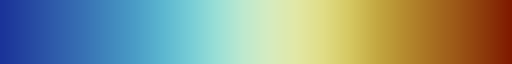

In [41]:
cmap

In [42]:
thresholds = [0, 10, 20, 40, 50, 60, 70, 100.0]

In [43]:
hexes = ['#1549b0','#62a3bf','#ffffff','#f5e464','#e39f39','#ff1212','#7d0f05']

In [44]:
import matplotlib

In [45]:
cmap = matplotlib.colors.ListedColormap(hexes, name='probabilities')

### parametrized terciles climatological values 

In [46]:
from matplotlib import pyplot as plt 
from cartopy import crs as ccrs

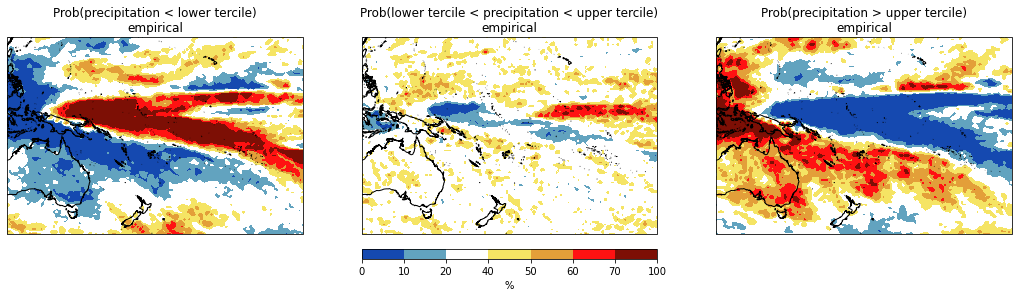

In [79]:
f, axes = plt.subplots(ncols=3, figsize=(18,8), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

ax = axes[0]
ax.coastlines(resolution='10m')
im1 = terciles_category_percent['precip'].sel(step=3, tercile=1).squeeze().plot.contourf(ax=ax, levels=thresholds, cmap=cmap, extend='neither', transform=ccrs.PlateCarree(), add_colorbar=False)
ax.set_title("Prob(precipitation < lower tercile)\nempirical")

ax = axes[1]
ax.coastlines(resolution='10m')
im2 = terciles_category_percent['precip'].sel(step=3, tercile=2).squeeze().plot.contourf(ax=ax, levels=thresholds, cmap=cmap, extend='neither', transform=ccrs.PlateCarree(), add_colorbar=False)
ax.set_title("Prob(lower tercile < precipitation < upper tercile)\nempirical")

cbar_ax = ax.axes.inset_axes([0, -0.125, 1, 0.05])

cb = plt.colorbar(im2, cax=cbar_ax, orientation='horizontal')

cb.set_label("%")

ax = axes[2]
ax.coastlines(resolution='10m')
im3 = terciles_category_percent['precip'].sel(step=3, tercile=3).squeeze().plot.contourf(ax=ax, levels=thresholds, cmap=cmap, extend='neither', transform=ccrs.PlateCarree(), add_colorbar=False, title='')
ax.set_title("Prob(precipitation > upper tercile)\nempirical")

f.savefig('/home/nicolasf/Desktop/C3S_ECMWF_OND_2021_empirical.png', dpi=200, bbox_inches='tight', facecolor='w')


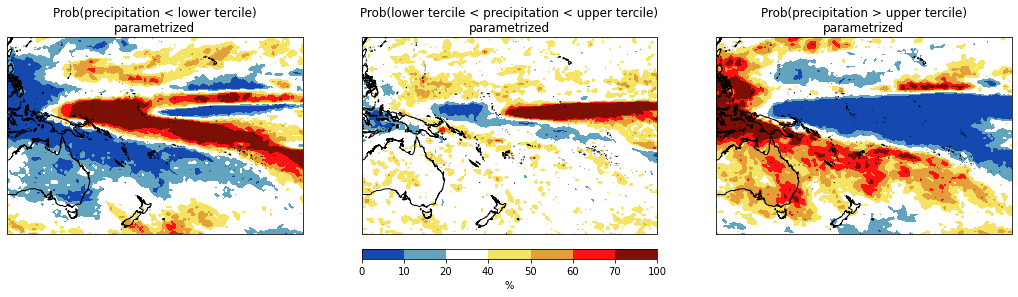

In [80]:
f, axes = plt.subplots(ncols=3, figsize=(18,8), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

ax = axes[0]
ax.coastlines(resolution='10m')
im1 = terciles_category_percent_parametrized['precip'].sel(step=3, tercile=1).squeeze().plot.contourf(ax=ax, levels=thresholds, cmap=cmap, extend='neither', transform=ccrs.PlateCarree(), add_colorbar=False)
ax.set_title("Prob(precipitation < lower tercile)\nparametrized")

ax = axes[1]
ax.coastlines(resolution='10m')
im2 = terciles_category_percent_parametrized['precip'].sel(step=3, tercile=2).squeeze().plot.contourf(ax=ax, levels=thresholds, cmap=cmap, extend='neither', transform=ccrs.PlateCarree(), add_colorbar=False)
ax.set_title("Prob(lower tercile < precipitation < upper tercile)\nparametrized")

cbar_ax = ax.axes.inset_axes([0, -0.125, 1, 0.05])

cb = plt.colorbar(im2, cax=cbar_ax, orientation='horizontal')

cb.set_label("%")

ax = axes[2]
ax.coastlines(resolution='10m')
im3 = terciles_category_percent_parametrized['precip'].sel(step=3, tercile=3).squeeze().plot.contourf(ax=ax, levels=thresholds, cmap=cmap, extend='neither', transform=ccrs.PlateCarree(), add_colorbar=False, title='')
ax.set_title("Prob(precipitation > upper tercile)\nparametrized")

f.savefig('/home/nicolasf/Desktop/C3S_ECMWF_OND_2021_parametrized.png', dpi=200, bbox_inches='tight', facecolor='w')


In [ ]:
for GCM in list_GCMs: 

    ### path to the CLIMATOLOGICAL terciles and deciles, 
    
    ### calculated over all the ensembles and month (for each initial month, i.e. leadtime dependent climatology) 
    
    # clim_path = gcm_path.joinpath(f'operational/hindcasts/CLIMATOLOGY/{GCM}')
   
    clim_path = gcm_path.joinpath(f'CLIMATOLOGY/{GCM}')
    
    tercile_climatology = xr.open_dataset(clim_path.joinpath(f"{GCM}_{period}_tercile_climatology_{str(month).zfill(2)}.netcdf"), engine='netcdf4')
    
    decile_climatology = xr.open_dataset(clim_path.joinpath(f"{GCM}_{period}_decile_climatology_{str(month).zfill(2)}.netcdf"), engine='netcdf4')
    
    percentile_climatology = xr.open_dataset(clim_path.joinpath(f"{GCM}_{period}_percentile_climatology_{str(month).zfill(2)}.netcdf"), engine='netcdf4')
    
    # make sure we have the same domains
    
    tercile_climatology = domains.extract_domain(tercile_climatology, domain)
    
    decile_climatology = domains.extract_domain(decile_climatology, domain)
    
    percentile_climatology = domains.extract_domain(percentile_climatology, domain)
    
    print(f"{50*'-'}\nReading forecasts issued {year}-{str(month).zfill(2)} for GCM {GCM}")

    x = xr.open_dataset(forecasts_path.joinpath(f"{GCM}/{varname.upper()}/ensemble_seas_forecasts_{varname}_from_{year}_{str(month).zfill(2)}_{GCM}.netcdf"), engine='netcdf4')

    ### preprocess (harmonize the variable names, sort the latitudes, etc )

    x = C3S.preprocess_GCM(x)

    ### convert from mm/day to mm/month 

    x = C3S.convert_rainfall(x, varin='tprate', varout='precip', leadvar='step', timevar='time', dropvar=True)

    ### just in case, remove potential missing fields (members)

    x = x.dropna(dim='member')
    
    ### make sure we have the same domain for the climatologies and the latest forecasts
    
    x = domains.extract_domain(x, domain)
    
    # calculates the seasonal values if period == seasonal

    if period == 'seasonal': 

        print("Calculating the seasonal (3 months) accumulations")

        x = x.rolling({'step':3}, min_periods=3, center=False).sum('step') 

        # get rid of the 2 first steps, which by definition contain missing values 

        x = x.sel(step=slice(3, None))

    ### checks that the initial month corresponds indeed to what we defined earlier 

    if (x.time.dt.year != year) or (x.time.dt.month != month): 

        print(f"issue with the initial date in the latest forecast, expected {year}-{month}, got {x.time.dt.year}-{x.time.dt.month}")

    ### Now calculates the tercile category for each member

    terciles_category = C3S.get_GCM_category_digitize(x, tercile_climatology.squeeze(), varname='precip', dim='quantile')

    ### and calculate the proportion of member in each category 
    
    terciles_category_percent = C3S.calculate_quantiles_probabilities(terciles_category, ncategories=3)
    
    ### same thing as abobe, for decile categories 

    deciles_category = C3S.get_GCM_category_digitize(x, decile_climatology.squeeze(), varname='precip', dim='quantile')

    deciles_category_percent = C3S.calculate_quantiles_probabilities(deciles_category, ncategories=10)

    ### same thing as above for percentile categories 
    
    percentiles_category = C3S.get_GCM_category_digitize(x, percentile_climatology.squeeze(), varname='precip', dim='quantile')

    percentiles_category_percent = C3S.calculate_quantiles_probabilities(percentiles_category, ncategories=21)
    
    ### creates a dummy 'GCM' dimension, and saves the tercile and decile probabilities to disk 

    terciles_category_percent = terciles_category_percent.expand_dims(dim={'GCM':[GCM]}, axis=0) 

    deciles_category_percent = deciles_category_percent.expand_dims(dim={'GCM':[GCM]}, axis=0) 

    percentiles_category_percent = percentiles_category_percent.expand_dims(dim={'GCM':[GCM]}, axis=0)

    # includes the quantile values (i.e. the 'bounds' for the quantile categories) in the dataset 

    terciles_category_percent.attrs['pct_values'] = tercile_climatology['quantile'].data
    deciles_category_percent.attrs['pct_values'] = decile_climatology['quantile'].data
    percentiles_category_percent.attrs['pct_values'] = percentile_climatology['quantile'].data

    ### saves to disk 
    
    print(f"saving the quantile probabilities in the folder {str(opath)}")

    terciles_category_percent.to_netcdf(opath.joinpath(f"{period}_terciles_probabilities_from_{date:%Y-%m}_{GCM}.netcdf")) 

    deciles_category_percent.to_netcdf(opath.joinpath(f"{period}_deciles_probabilities_from_{date:%Y-%m}_{GCM}.netcdf")) 

    percentiles_category_percent.to_netcdf(opath.joinpath(f"{period}_percentiles_probabilities_from_{date:%Y-%m}_{GCM}.netcdf")) 

    print(f"\n{GCM} {period} forecasts from {year}-{str(month).zfill(2)} processed and saved in {str(opath)}...\n")
